# Introduction
Churn analysis is a critical process used by businesses to understand the rate at which customers stop doing business with them, also known as "churn." The primary goal of churn analysis is to identify patterns and factors that lead to customer attrition, enabling companies to take proactive measures to retain customers and reduce churn rates.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE


# Data Loading and Cleaning

In [2]:
df = pd.read_csv('churn-data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,"PhoneService,PaperlessBilling"
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No Yes
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,Yes No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Yes Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No No
4,9237-HQITU,NaN,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Yes Yes


In [3]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customerID                     7043 non-null   object 
 1   gender                         6943 non-null   object 
 2   SeniorCitizen                  7043 non-null   int64  
 3   Partner                        6943 non-null   object 
 4   Dependents                     7043 non-null   object 
 5   tenure                         7043 non-null   int64  
 6   PhoneService                   7043 non-null   object 
 7   MultipleLines                  7043 non-null   object 
 8   InternetService                7043 non-null   object 
 9   OnlineSecurity                 7043 non-null   object 
 10  OnlineBackup                   7043 non-null   object 
 11  DeviceProtection               7043 non-null   object 
 12  TechSupport                    7043 non-null   o

In [5]:
cols = df.select_dtypes(include='object').columns
df[cols] = df[cols].apply(lambda x: x.str.strip())

In [6]:
df['gender'].value_counts(dropna=False)

,count
gender,
Male,3508
Female,3435
NaN,100


In [7]:
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
df['gender'] = df['gender'].replace({"Male": 1, "Female":0})

<ipython-input-7-f1a862568322>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({"Male": 1, "Female":0})


In [8]:
df['Partner'].value_counts(dropna=False)

,count
Partner,
No,3592
Yes,3351
NaN,100


In [9]:
df['Partner'] = df['Partner'].fillna(df['Partner'].mode()[0])
df['Partner'] = df['Partner'].replace({"Yes": 1, "No":0})

<ipython-input-9-92191e4366f9>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Partner'] = df['Partner'].replace({"Yes": 1, "No":0})


In [10]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'PhoneService,PaperlessBilling'],
      dtype='object')

In [11]:
# Since we have same columns, these ones will be dropped
df.drop(columns='PhoneService,PaperlessBilling', axis=1, inplace=True)

In [12]:
df.describe(include='object')

,customerID,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [13]:
two_unique_cols = [col for col in df.columns if df[col].nunique() == 2]

for col in df[two_unique_cols]:
    print(f"{col}: {df[col].unique()}")

gender: [0 1]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
PaperlessBilling: ['Yes' 'No']
Churn: ['No' 'Yes']


In [14]:
df[two_unique_cols] = df[two_unique_cols].replace({'No': 0, 'Yes': 1})

<ipython-input-14-37bae371bde7>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[two_unique_cols] = df[two_unique_cols].replace({'No': 0, 'Yes': 1})


In [15]:
three_unique_cols = [col for col in df.columns if df[col].nunique() == 3]

for col in df[three_unique_cols]:
    print(f"{col}: {df[col].unique()}")

MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']


In [16]:
encoder = LabelEncoder()

for c in three_unique_cols:
    df[c] = encoder.fit_transform(df[c])

In [17]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [18]:
encoder = LabelEncoder()
df['PaymentMethod'] = encoder.fit_transform(df['PaymentMethod'])

In [19]:
df['TotalCharges'].value_counts()

,count
TotalCharges,
,11
20.2,11
19.75,9
20.05,8
19.9,8
...,...
6849.4,1
692.35,1
130.15,1


<Axes: ylabel='Density'>

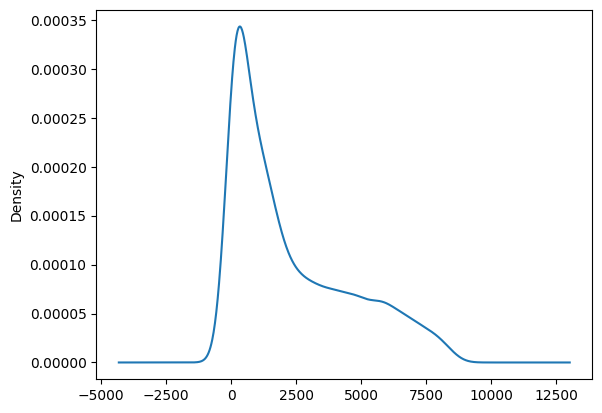

In [20]:
df['TotalCharges'] = df['TotalCharges'].replace('', np.nan).astype(float)
df['TotalCharges'].plot(kind='density')

In [21]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mode()[0])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


<Axes: ylabel='TotalCharges'>

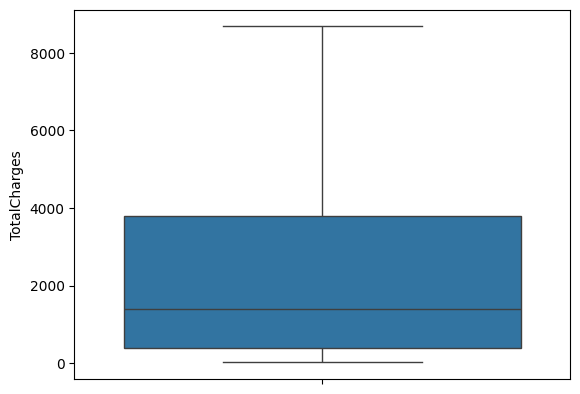

In [23]:
sns.boxplot(df['TotalCharges'])

<Axes: ylabel='MonthlyCharges'>

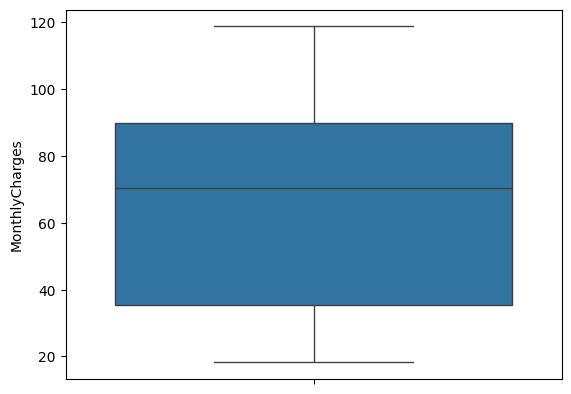

In [24]:
sns.boxplot(df['MonthlyCharges'])

# Model Building and Results

In [25]:
df['customerID'] = np.arange(len(df['customerID']))

In [26]:
x = df.drop(columns="Churn")
y = df["Churn"]

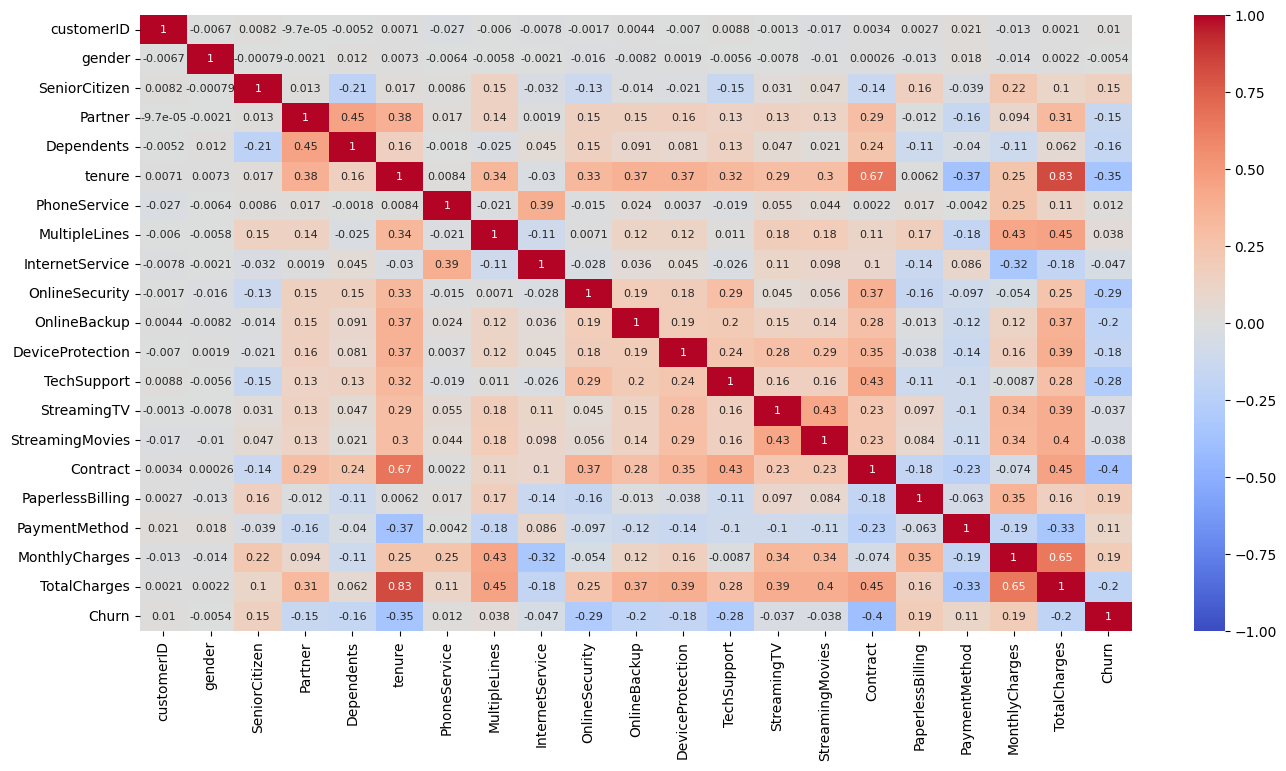

In [27]:
cm = df.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.show()

In [28]:
rfe = RFE(LogisticRegression(max_iter=5000), n_features_to_select=10)
x_selected_rfe = rfe.fit_transform(x, y)

x_train, x_test, y_train, y_test = train_test_split(x_selected_rfe, y, test_size=0.2, random_state=42)

In [29]:
models = []

def results(model, name):
    global models

    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=1)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)

    print(f"accuracy: {acc}\nf1-score: {f1}\nprecision: {pre}\nrecall: {rec}")

    models.append({
        'Model': name,
        'Accuracy': acc,
        'F1': f1,
        'Precision': pre,
        'Recall': rec
    })

In [30]:
log = LogisticRegression(random_state=42, max_iter=10000)
log.fit(x_train, y_train)

results(log, "Logistic Regression")

accuracy: 0.794180269694819
f1-score: 0.5579268292682927
precision: 0.6466431095406361
recall: 0.4906166219839142


In [31]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train, y_train)

results(tree, "Decision Tree")

accuracy: 0.723207948899929
f1-score: 0.46866485013623976
precision: 0.47645429362880887
recall: 0.46112600536193027


In [32]:
random = RandomForestClassifier(random_state=42)
random.fit(x_train, y_train)
results(random, "RandomForest")

accuracy: 0.7466288147622427
f1-score: 0.5156037991858887
precision: 0.521978021978022
recall: 0.5093833780160858


In [33]:
svc = SVC(random_state=42)
svc.fit(x_train, y_train)

results(svc, "SVC")

accuracy: 0.7835344215755855
f1-score: 0.49917898193760263
precision: 0.6440677966101694
recall: 0.4075067024128686


In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_dim=x_train.shape[1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation= 'relu', kernel_regularizer = 'l1'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7453 - loss: 26.7308 - val_accuracy: 0.7601 - val_loss: 0.7523
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7715 - loss: 0.7413 - val_accuracy: 0.7842 - val_loss: 0.6796
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7795 - loss: 0.8111 - val_accuracy: 0.7864 - val_loss: 0.6491
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7847 - loss: 0.6504 - val_accuracy: 0.7864 - val_loss: 0.6273
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8001 - loss: 0.6374 - val_accuracy: 0.7842 - val_loss: 0.6098
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7943 - loss: 0.6119 - val_accuracy: 0.7921 - val_loss: 0.6088
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7937 - loss: 0.6090 - val_accuracy: 0.7899 - val_loss: 0.5972
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7897 - loss: 0.6200 - val_acc

In [35]:
y_pred = (model.predict(x_test) > 0.5).astype(int).reshape(-1)

acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

models.append({
        'Model': "Neural Network",
        'Accuracy': acc,
        'F1': f1,
        'Precision': pre,
        'Recall': rec
    })

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [36]:
# Results of all Models
results_df = pd.DataFrame(models)
results_df.T

,0,1,2,3,4
Model,Logistic Regression,Decision Tree,RandomForest,SVC,Neural Network
Accuracy,0.79418,0.723208,0.746629,0.783534,0.792051
F1,0.557927,0.468665,0.515604,0.499179,0.59021
Precision,0.646643,0.476454,0.521978,0.644068,0.616959
Recall,0.490617,0.461126,0.509383,0.407507,0.565684
